In [1]:
pip install lime

     |████████████████████████████████| 276kB 7.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=d1eb0728d8a0962c0b8335c35bc7a513caacdad29126de3e9d57d00ab25cc081
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from google.colab import drive, files
drive.mount('/content/drive')

from keras import layers, models, Input, optimizers, initializers, regularizers, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16, VGG19

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

tf.random.set_seed(36)

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/My Drive/Xray_data/'
result_dir = base_dir + 'result_npy/'

In [ ]:
from google.colab import files


def plot_result(hist, cf_mat, test_res):
    hist_dict = hist.history
    acc = hist_dict['acc']
    val_acc = hist_dict['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(1, len(acc) + 1)
    epochs_num = epochs[-1]

    total_acc = test_res[1]
    recall_nor_vs = (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2]) / (
        cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2] + cf_mat[1][0] + cf_mat[2][0])
    precision_nor_vs = (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2]) / (
        cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2] + cf_mat[0][1] + cf_mat[0][2])
    f1_score_nor_vs = 2*recall_nor_vs*precision_nor_vs / \
        (recall_nor_vs + precision_nor_vs)

    acc_cov_pne = (cf_mat[1][1] + cf_mat[2][2]) / (cf_mat[1]
                                                   [1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2])
    recall_cov_pne = cf_mat[2][2] / (cf_mat[2][1] + cf_mat[2][2])
    perf_y = [total_acc, recall_nor_vs, precision_nor_vs,
              f1_score_nor_vs, acc_cov_pne, recall_cov_pne]
    perf_x = ['acc(total)', 'recall(nor vs)', 'precision(nor vs)',
              'f1(nor vs)', 'acc(cov&pne)', 'recall(cov&pne)']

    plt.style.use(['seaborn'])
    fig = plt.figure(figsize=(18, 5))

    if epochs_num//5 < 1:
        x_interval = 1
    else:
        x_interval = epochs_num//5

    fig.add_subplot(1, 3, 1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy', size=18)
    plt.xlabel('Epochs', size=14)
    plt.xticks(list(range(1, epochs_num+1, x_interval)))
    plt.ylabel('Accuracy', size=14)
    plt.legend()

    ax2 = fig.add_subplot(1, 3, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', size=18)
    plt.xlabel('Epochs', size=14)
    plt.xticks(list(range(1, epochs_num+1, x_interval)))
    plt.ylabel('Accuracy', size=14)
    plt.legend()

    ax3 = fig.add_subplot(1, 3, 3)
    plt.plot(perf_x, perf_y)
    plt.title('Model performance evaluation', size=18)
    plt.xticks(size=12, rotation=45)
    plt.show()


def true_label_ftn(label_):
    tr_label = []
    for i in label_:
        for th, j in enumerate(i):
            if j == 1:
                tr_label.append(th)

    return np.array(tr_label)


def print_result(res_name, res, per=0):
    if per:
        print('{0:^35} |  {1:0.4f}'.format(res_name, res))
    else:
        print('{0:^35} |  {1:0.2f}%'.format(res_name, res*100))


def model_performance(mod, hist, data_, label_, model_name=''):

    test_results = mod.evaluate(data_, label_, verbose=0)
    tr_label = true_label_ftn(label_)
    pred_c = mod.predict(data_)
    pred_c = np.argmax(pred_c, axis=1)

    index_list = ['NORMAL', 'PNEUMONIA', 'COVID19']
    cf_mat = confusion_matrix(tr_label, pred_c)
    cf_df = pd.DataFrame(cf_mat, index=index_list, columns=index_list)

    print('\n')
    plot_result(hist, cf_mat, test_results)
    print('\n')

    fig = plt.figure(figsize=(8, 7))
    sns.heatmap(cf_df, annot=True, cmap='Blues',
                fmt='d', annot_kws={"size": 14})
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted label', fontsize=16)
    plt.ylabel('True label', fontsize=16)

    plt.show()

    save_perform = hist.history
    save_perform['cf_mat'] = cf_mat
    save_perform['mod_eval'] = test_results
    if model_name == '':
        np.save('model_performance_save', np.array(save_perform))
        files.download('model_performance_save.npy')
    else:
        np.save('{0}_performance_savefile'.format(
            model_name), np.array(save_perform))
        files.download('{0}_performance_savefile'.format(model_name)+'.npy')

In [4]:
train_data = np.load(base_dir + 'train_data128_pre.npy')
test_data = np.load(base_dir + 'test_data128_pre.npy')

In [5]:
train_label = np.load(base_dir + 'train_label128_pre.npy')
test_label = np.load(base_dir + 'test_label128_pre.npy')

# 1. Plot Graphs

In [6]:
result_dir2 = base_dir + 'result2_npy/'

In [8]:
def npy_results_plot(res_df):
    plt.style.use(['default'])

    ax1 = res_df[['train_acc', 'test_acc', 'recall(nor)', 'recall(cov&pne)']].plot(
        color=sns.color_palette('Pastel1')[3:4]+sns.color_palette('bright')[:3])
    ax1.set_ylabel('Accuracy', size=11)
    plt.xticks(size=12, rotation=40)

    ax2 = ax1.twinx()
    res_df['train - val acc'].plot(kind='bar',
                                   color=sns.color_palette('Set2')[6], alpha=0.2)
    ax2.set_ylabel('Train - Val. Accuracy', size=11)
    #ax2.legend(loc='lower right')
    plt.title('Model performance', size=20)

    plt.show()


def npy_results(_dir, zoom=False):
    res_npy_list = os.listdir(_dir)
    res_npy_list.sort()

    plt.figure(figsize=(15, 9))
    summary_set = {}
    for i in res_npy_list:
        npy_res = np.load(_dir + i, allow_pickle=True)
        npy_res = npy_res.tolist()

        train_acc = npy_res['acc'][-1]
        val_acc = npy_res['val_acc'][-1]
        test_acc = npy_res['mod_eval'][-1]
        cf_mat = npy_res['cf_mat']

        recall_nor = (cf_mat[1][1] + cf_mat[1][2] + cf_mat[2][1] + cf_mat[2][2]) / (
            cf_mat[1][0] + cf_mat[2][0] + cf_mat[1][1] + cf_mat[1][2] + cf_mat[2][1] + cf_mat[2][2])
        recall_cov_pne = cf_mat[2][2] / (cf_mat[2][1] + cf_mat[2][2])

        x_names = ['train_acc', 'val_acc', 'test_acc',
                   'recall(nor)', 'recall(cov&pne)']
        x_values = [train_acc, val_acc, test_acc, recall_nor, recall_cov_pne]

        mod_name = i[:i.find('_')]

        summary_set[mod_name] = [round(n, 4) for n in x_values]

    sum_df = pd.DataFrame(summary_set, index=x_names).T

    sum_df['train - val acc'] = sum_df['train_acc'] - sum_df['val_acc']
    npy_results_plot(sum_df)

    return sum_df

<Figure size 1080x648 with 0 Axes>

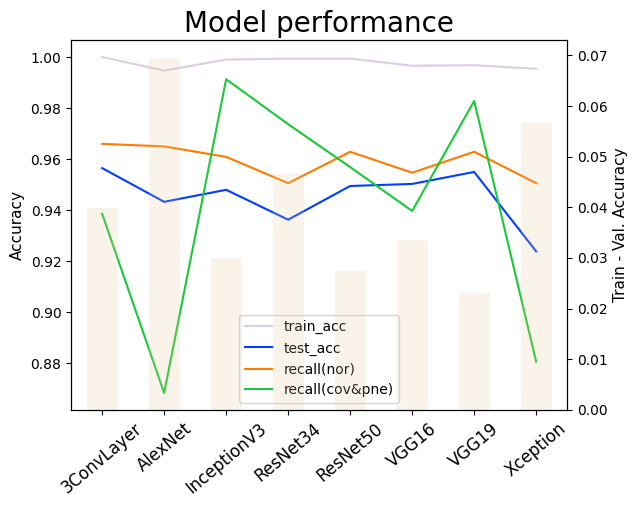

train_acc  val_acc  ...  recall(cov&pne)  train - val acc
3ConvLayer      1.0000   0.9602  ...           0.9386           0.0398
AlexNet         0.9947   0.9252  ...           0.8684           0.0695
InceptionV3     0.9990   0.9690  ...           0.9913           0.0300
ResNet34        0.9994   0.9529  ...           0.9737           0.0465
ResNet50        0.9994   0.9719  ...           0.9569           0.0275
VGG16           0.9966   0.9631  ...           0.9397           0.0335
VGG19           0.9968   0.9738  ...           0.9828           0.0230
Xception        0.9954   0.9388  ...           0.8807           0.0566

[8 rows x 6 columns]

In [9]:
npy_results(result_dir)

<Figure size 1500x900 with 0 Axes>

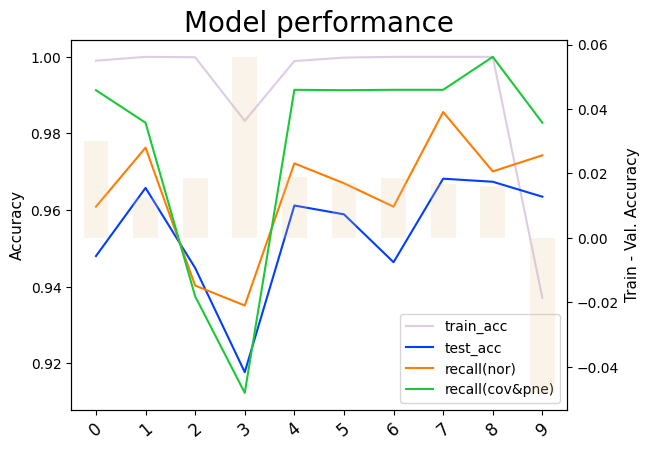

train_acc  val_acc  test_acc  recall(nor)  recall(cov&pne)  train - val acc
0     0.9990   0.9690    0.9480       0.9609           0.9913           0.0300
1     1.0000   0.9876    0.9658       0.9763           0.9828           0.0124
2     0.9999   0.9814    0.9449       0.9403           0.9375           0.0185
3     0.9833   0.9271    0.9177       0.9351           0.9123           0.0562
4     0.9989   0.9800    0.9612       0.9722           0.9914           0.0189
5     0.9998   0.9829    0.9589       0.9670           0.9913           0.0169
6     1.0000   0.9814    0.9464       0.9609           0.9914           0.0186
7     1.0000   0.9833    0.9682       0.9856           0.9914           0.0167
8     1.0000   0.9838    0.9674       0.9701           1.0000           0.0162
9     0.9371   0.9852    0.9635       0.9743           0.9828          -0.0481

In [10]:
npy_results(result_dir2)

# 2. Prediction Visualization(LIME, Local Interpretable Model-agnostic Explanations)

In [ ]:
def plot_pred(mod, _data, _label, num=5, diff=False):
    label_dict = {0: 'Normal', 1: 'Pneuomnia', 2: 'Covid19'}
    pred_cl = mod.predict(_data)

    diff_list = []
    for i in range(len(_label)):
        if np.argmax(pred_cl[i]) != np.argmax(_label[i]):
            diff_list.append(i)

    if diff:
        ran_list = diff_list[:num]
    else:
        ran_list = range(num)

    for i in ran_list:

        if np.argmax(pred_cl[i]) != np.argmax(_label[i]):
            color = 'red'
        else:
            color = 'blue'

        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            _data[i], mod.predict, top_labels=3, hide_color=0, num_samples=2000)
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=True)
        ind = explanation.top_labels[0]
        dict_heatmap = dict(explanation.local_exp[ind])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

        im = plt.imshow(heatmap, cmap=sns.color_palette(
            "coolwarm_r", as_cmap=True), vmin=-heatmap.max(), vmax=heatmap.max())
        plt.colorbar(im)
        plt.show()

        fig = plt.figure(figsize=(13, 4))
        fig.add_subplot(1, 3, 1)
        plt.imshow(_data[i])
        plt.title('Actual class : {0}'.format(
            label_dict[np.argmax(_label[i])]), fontsize=16)
        plt.grid(False)
        plt.axis('off')

        fig.add_subplot(1, 3, 2)
        plt.imshow(mark_boundaries(temp, mask))
        plt.title('Visualization of detection', fontsize=16)
        plt.grid(False)
        plt.axis('off')

        fig.add_subplot(1, 3, 3)
        fig.subplots_adjust(wspace=0.4)
        plt.barh(['Normal', 'Pneumonia', 'Covid19'], pred_cl[i],
                 color=sns.color_palette('Blues')[1:])
        ax2 = plt.gca()

        for p in ax2.patches:
            left, bottom, width, height = p.get_bbox().bounds
            ax2.annotate("%.1f%%" % (width*100), (0.05, bottom +
                         height/2.7), ha='left', fontsize=10)

        ax2.set_aspect(0.2)
        plt.xticks(np.arange(0, 1.1, 0.2))
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        for tic in ax2.yaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
        plt.title('Predicted class : {0}'.format(
            label_dict[np.argmax(pred_cl[i])]), fontsize=16, color=color)

        plt.show()

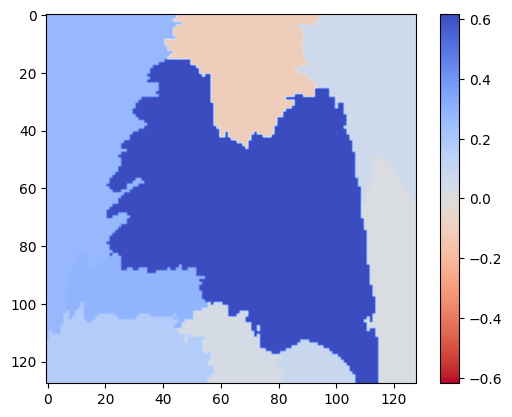

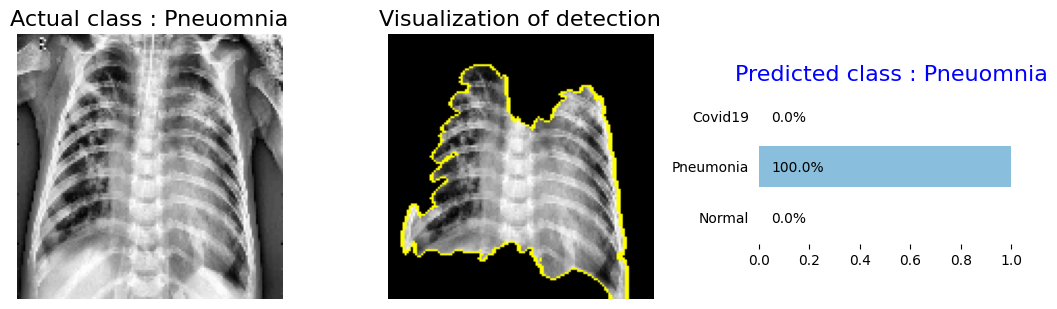

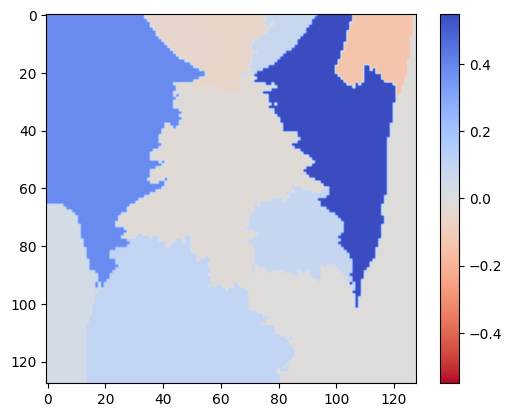

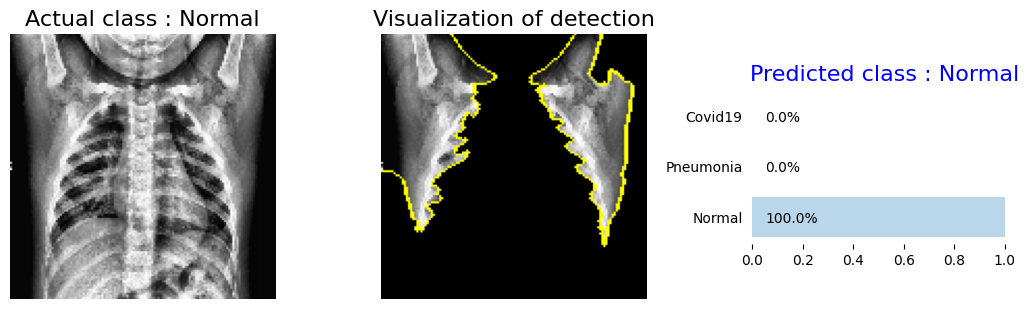

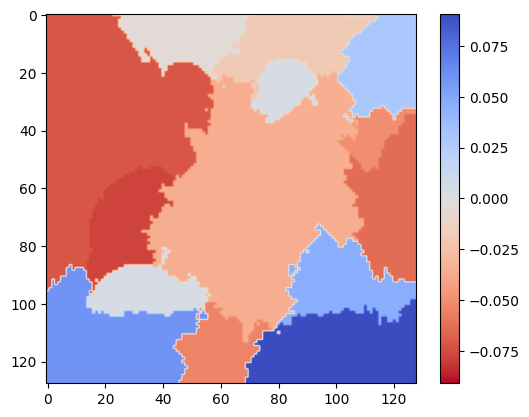

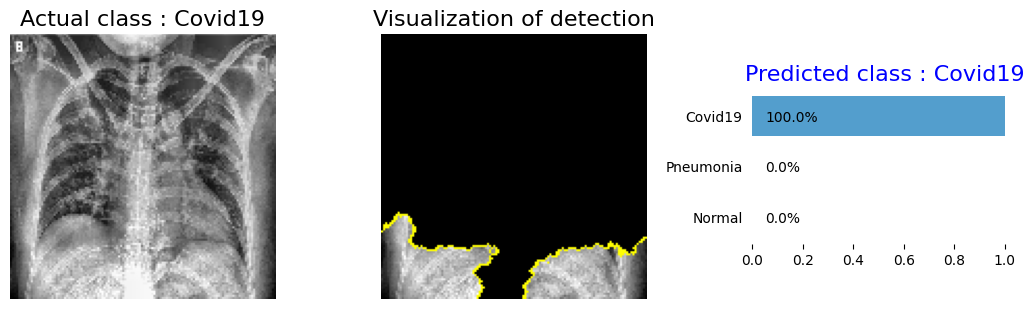

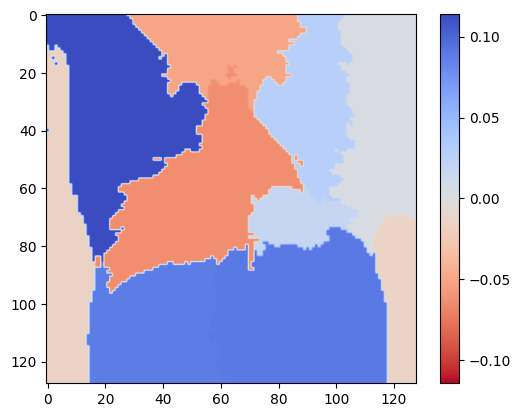

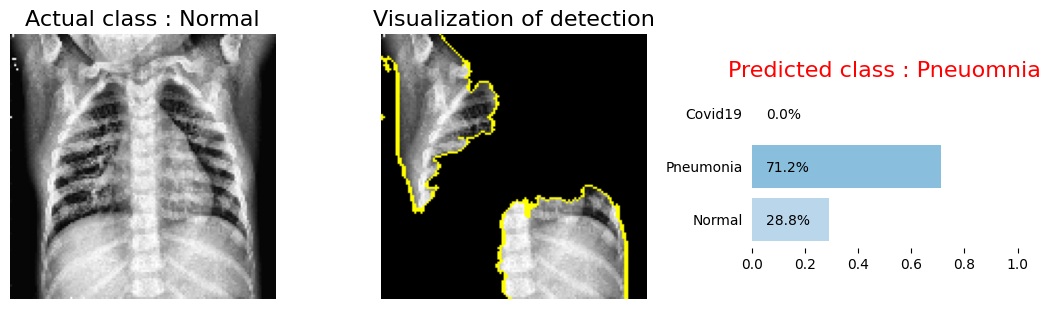

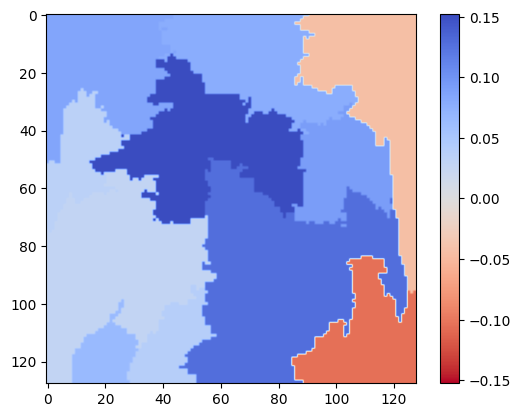

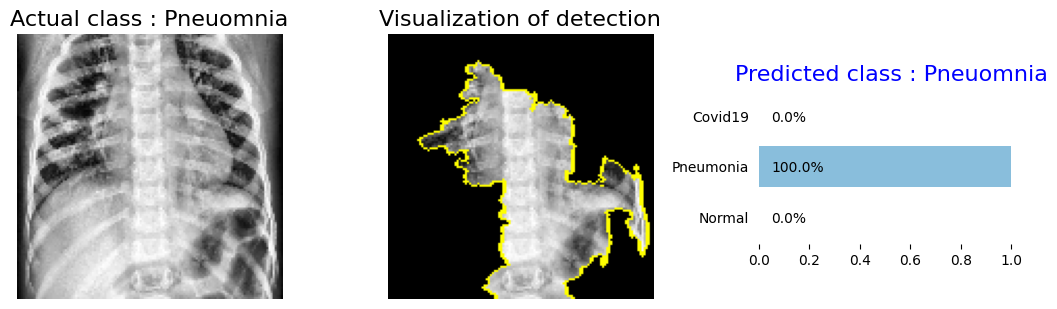

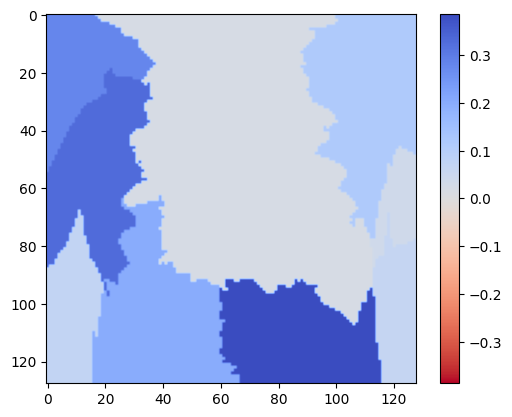

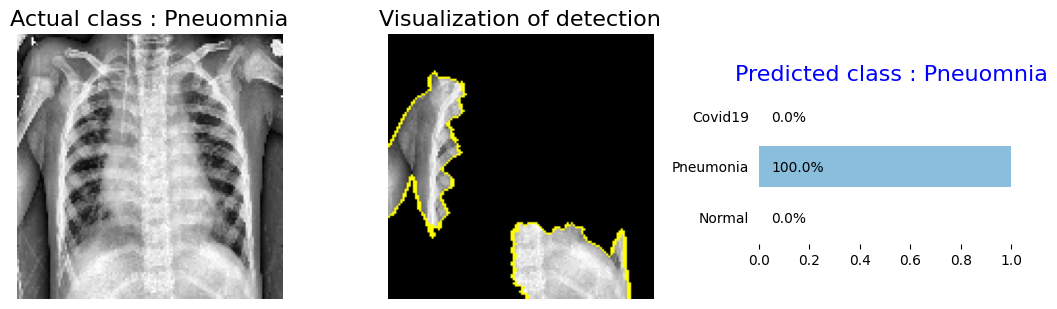

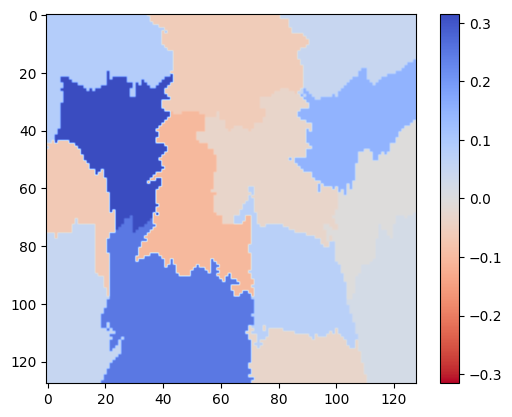

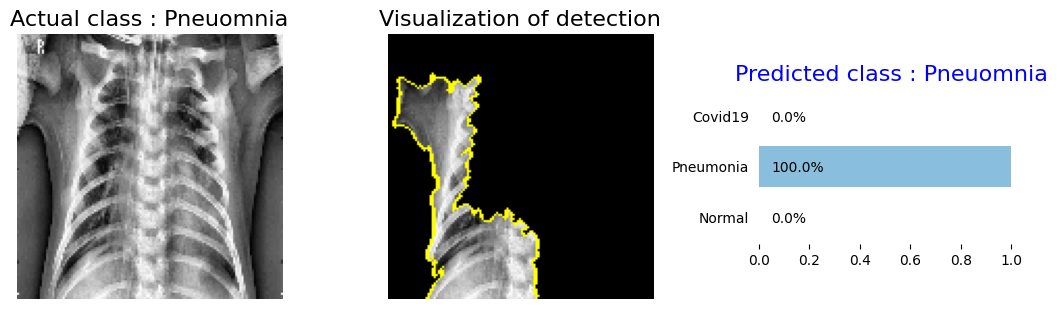

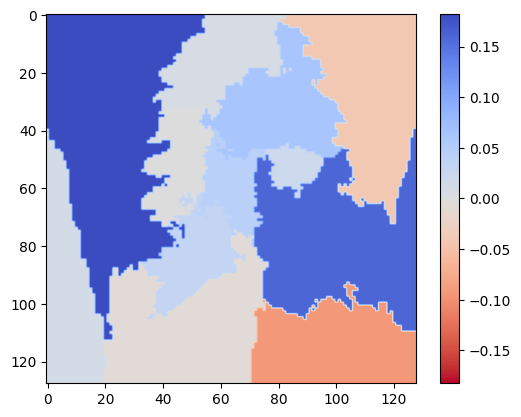

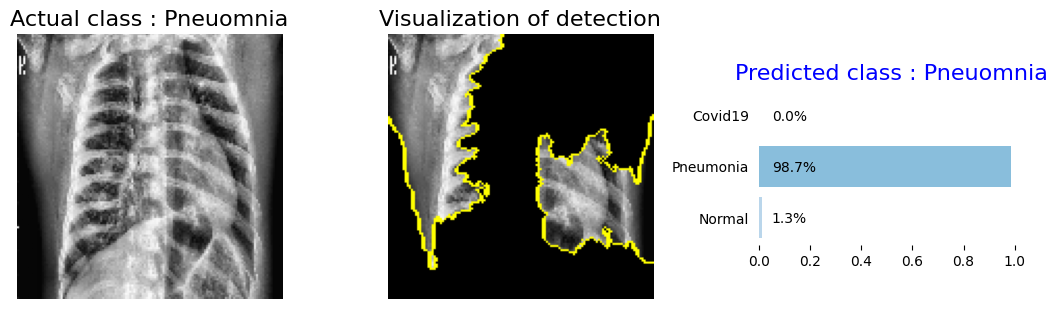

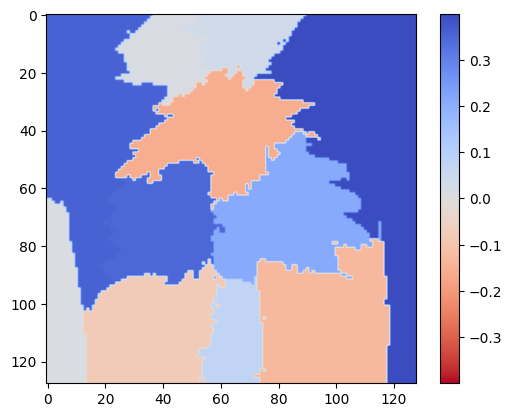

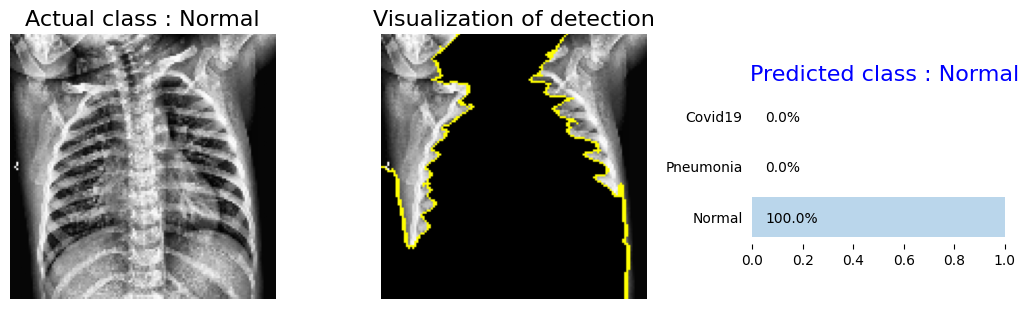

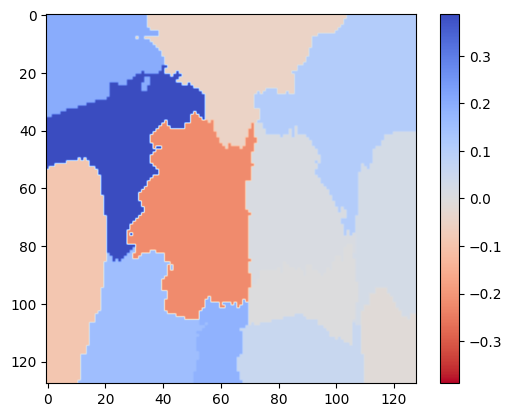

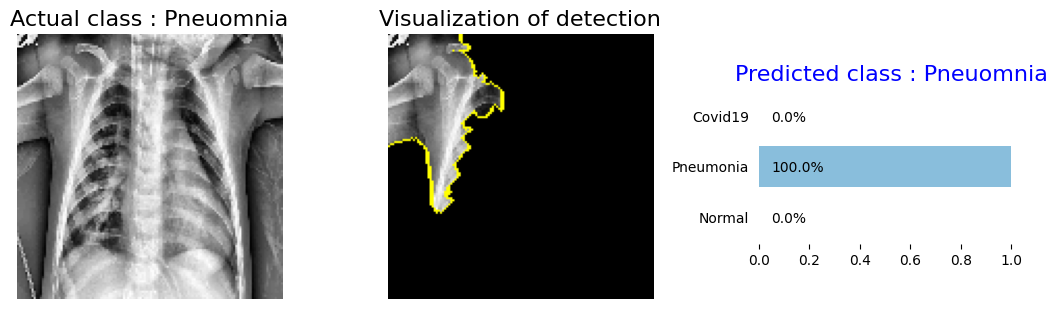

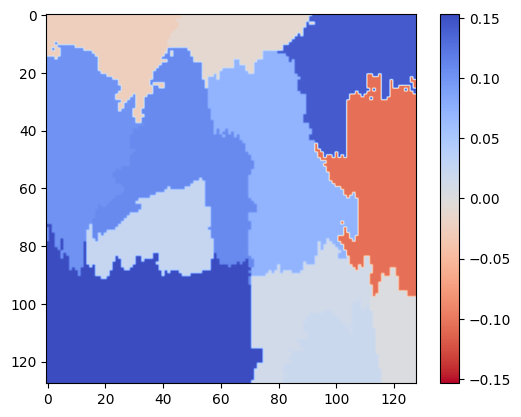

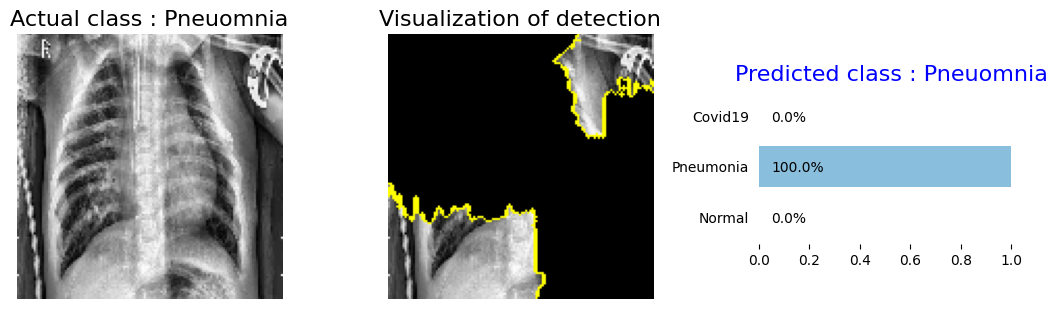

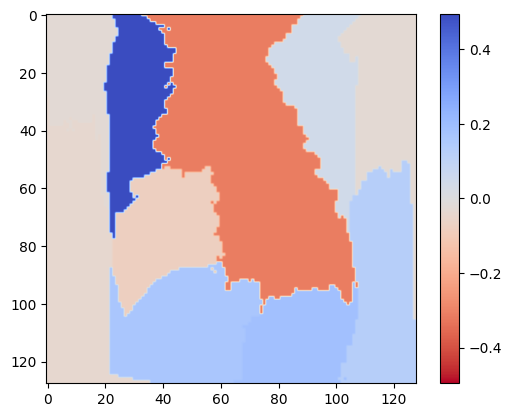

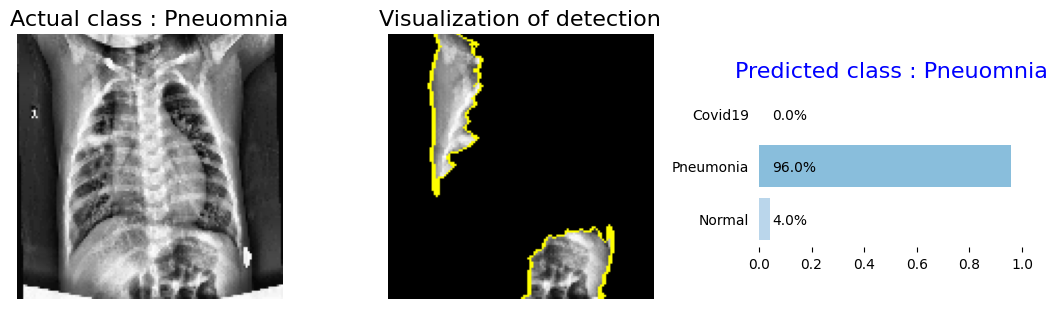

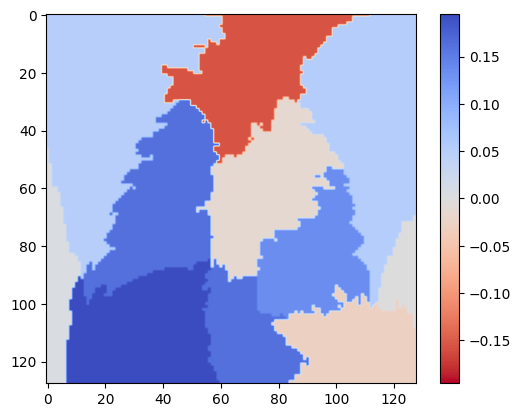

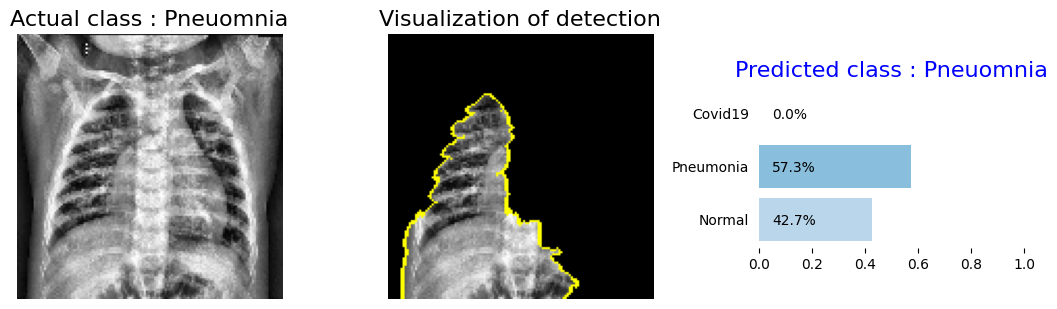

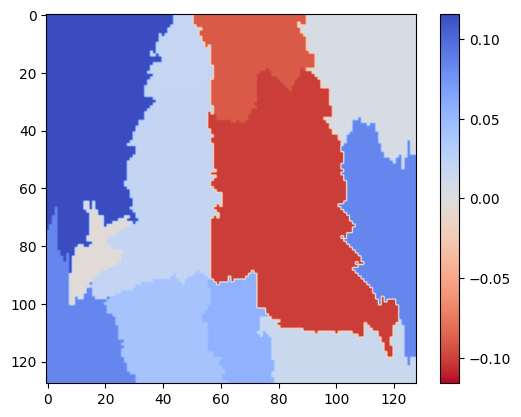

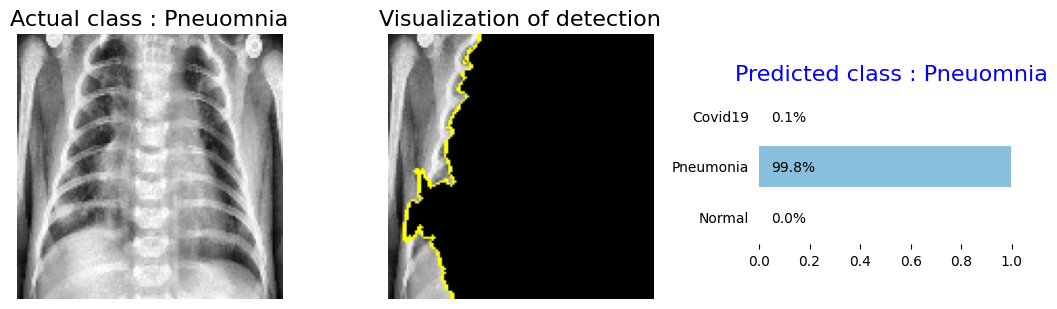

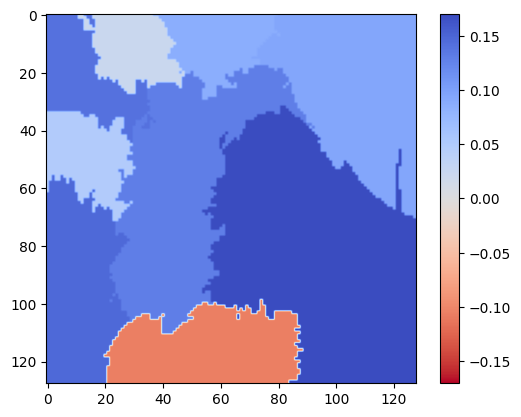

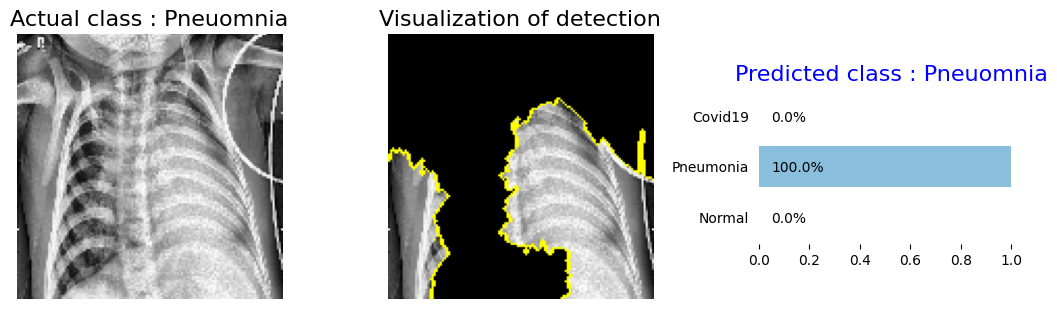

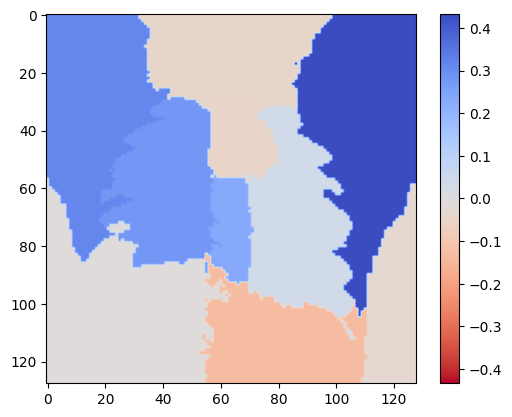

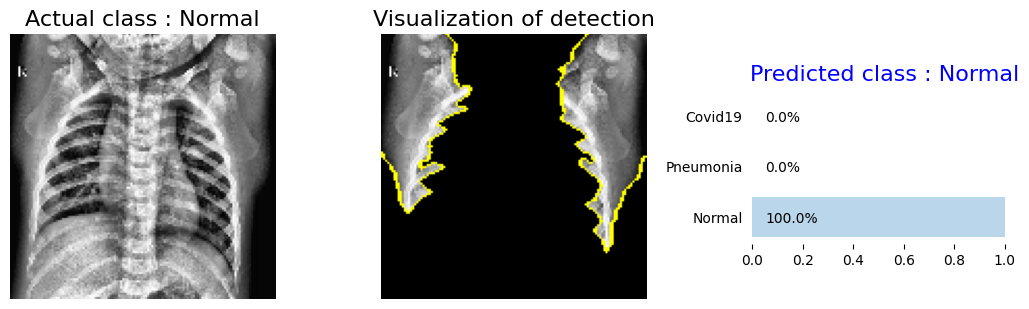

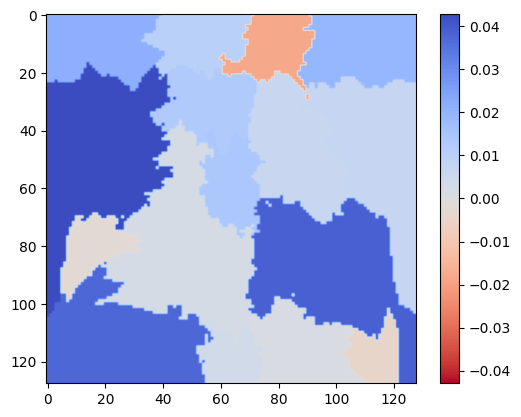

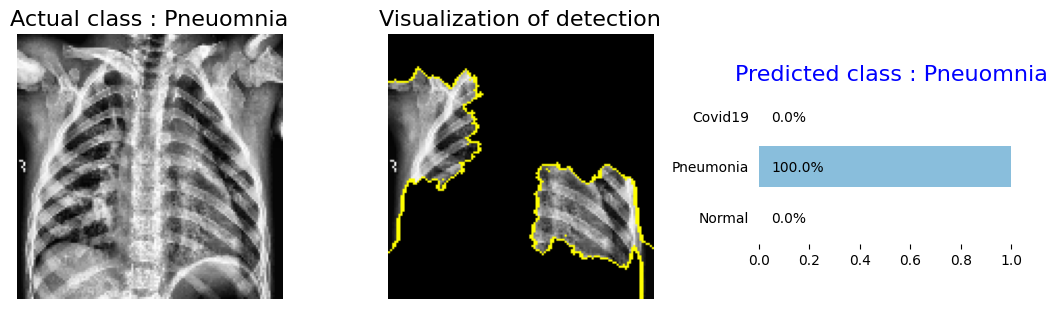

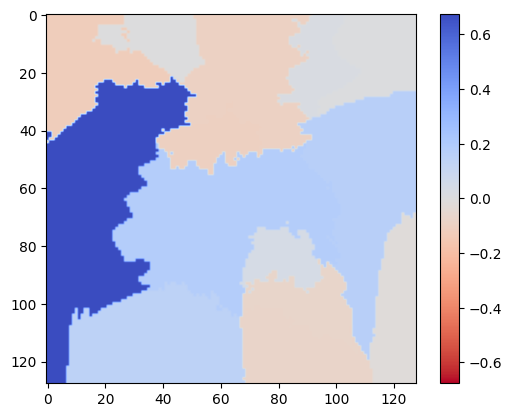

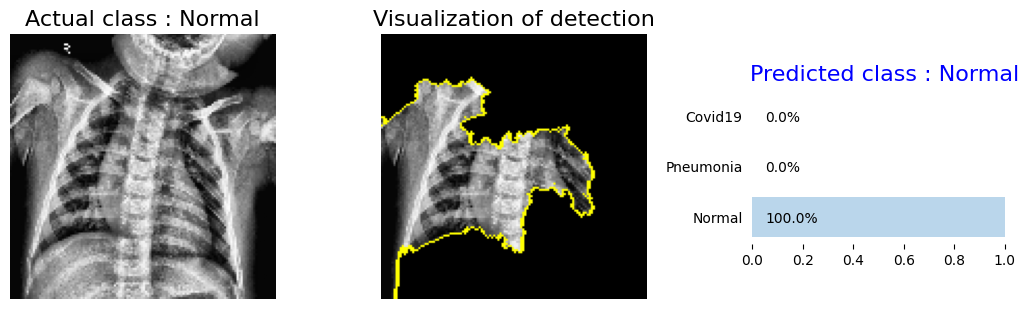

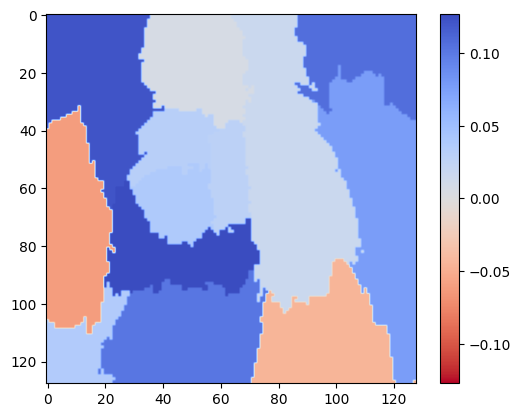

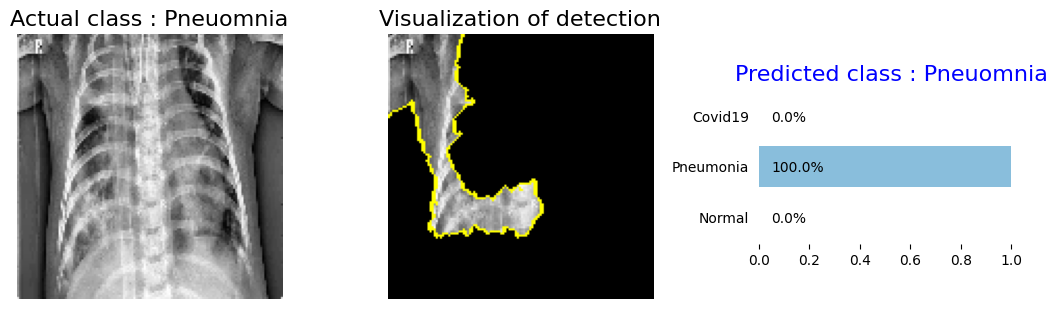

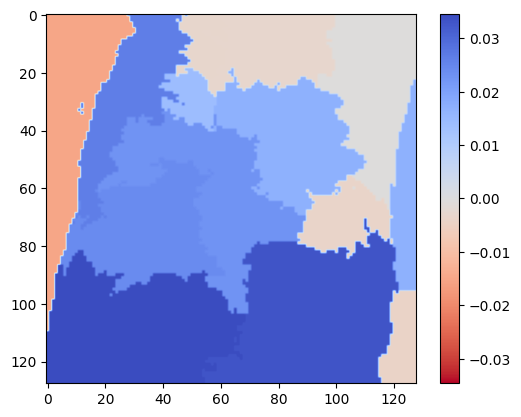

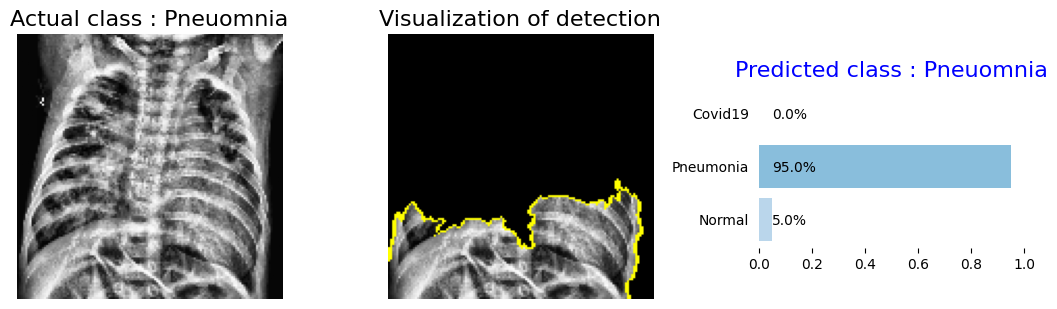

In [ ]:
plot_pred(model, test_data, test_label, 20)